In [1]:
%matplotlib inline
import numpy as np
import cv2
import matplotlib.pyplot as plt
from imutils import paths
import dlib

In [2]:
image_paths = list(paths.list_images("../data/images/presidents"))

In [3]:
images = []
for image_path in image_paths:
    images.append(cv2.imread(image_path))

In [4]:
face_detector = dlib.get_frontal_face_detector()
landmark_detector = dlib.shape_predictor("../data/models/shape_predictor_68_face_landmarks.dat")

In [5]:
def get_points(landmarks):
    points = []
    for i in range(len(landmarks.parts())):
        points.append((landmarks.part(i).x,landmarks.part(i).y))
        
    return points

In [6]:
aligned_images = []
aligned_points = []
for image in images:
    image_rgb = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    face_rects = face_detector(image_rgb,0)
    for i in range(len(face_rects)):
        new_rect = dlib.rectangle(int(face_rects[i].left()),
                                 int(face_rects[i].top()),
                                 int(face_rects[i].right()),
                                 int(face_rects[i].bottom()))
        
        landmarks = landmark_detector(image_rgb,new_rect)
        
        points = get_points(landmarks)
        
        output_height,output_width = 600,600
        points_src = [points[36],points[45]]
        points_dst = [(int(0.3*output_width),int(output_height/3)),(int(0.7*output_width),int(output_height/3))]
        
    cos_theta = np.cos(60*np.pi/180)
    sin_theta = np.sin(60*np.pi/180)
    point_src_x = cos_theta*(points_src[0][0] - points_src[1][0]) + sin_theta*(points_src[0][1] - points_src[1][1]) + points_src[1][0]
    point_src_y = -sin_theta*(points_src[0][0] - points_src[1][0]) + cos_theta*(points_src[0][1] - points_src[1][1]) + points_src[1][1]
    
    point_dst_x = cos_theta*(points_dst[0][0] - points_dst[1][0]) + sin_theta*(points_dst[0][1] - points_dst[1][1]) + points_dst[1][0]
    point_dst_y = -sin_theta*(points_dst[0][0] - points_dst[1][0]) + cos_theta*(points_dst[0][1] - points_dst[1][1]) + points_dst[1][1]
    points_src.append((point_src_x,point_src_y))
    points_dst.append((point_dst_x,point_dst_y))
    
    points_src = np.float32(points_src).reshape(-1,1,2)
    points_dst = np.float32(points_dst).reshape(-1,1,2)
    warp_mat = cv2.estimateAffinePartial2D(points_src,points_dst)[0]
    
    points = np.float32(points).reshape(-1,1,2)
    output_points = cv2.transform(points,warp_mat)
    output_image = cv2.warpAffine(image,warp_mat,(output_width,output_height))
    
    
    aligned_images.append(output_image)
    aligned_points.append(output_points)

In [7]:
aligned_points = np.float32(aligned_points)

In [8]:
final_aligned_points = aligned_points.mean(axis = 0)

In [9]:
final_aligned_points.shape

(68, 1, 2)

In [10]:
def warp_triangle(image,output,tri_in,tri_out):
    rect1 = cv2.boundingRect(tri_in)
    rect2 = cv2.boundingRect(tri_out)
    
    tri_in_cropped = []
    tri_out_cropped = []
    for i in range(tri_in.shape[1]):
        tri_in_cropped.append([(tri_in[0][i][0] - rect1[0]),(tri_in[0][i][1] - rect1[1])])
        tri_out_cropped.append([(tri_out[0][i][0] - rect2[0]),(tri_out[0][i][1] - rect2[1])])
        
    warp_mat = cv2.getAffineTransform(np.float32(tri_in_cropped),np.float32(tri_out_cropped))
    image_1_cropped = image.copy()[rect1[1]:rect1[1]+rect1[3],rect1[0]:rect1[0]+rect1[2]]
    image_2_cropped = cv2.warpAffine(image_1_cropped,warp_mat,(rect2[2],rect2[3]),
                                    None,flags=cv2.INTER_LINEAR,
                              borderMode=cv2.BORDER_REFLECT_101)
    
    mask = np.zeros((rect2[3],rect2[2],3),dtype = np.uint8)
    cv2.fillConvexPoly(mask,np.int32(tri_out_cropped),(255,255,255))
    mask = np.float32(mask)/255.0
    
    image_2_cropped = (image_2_cropped*mask).astype(np.uint8)
    
    inverse_mask = ((1.0 - mask)*255).astype(np.uint8)
    output_cropped = cv2.add(image_2_cropped,inverse_mask)
    
    output[rect2[1]:rect2[1]+rect2[3],rect2[0]:rect2[0]+rect2[2]] = output_cropped
    
    return output

In [14]:
output_aligned_images = []
for i in range(6):
    rect = (0,0,600,600)
    subdiv_input = cv2.Subdiv2D(rect)
    subdiv_output = cv2.Subdiv2D(rect)

    input_image = aligned_images[i]
    image_rgb = cv2.cvtColor(input_image,cv2.COLOR_BGR2RGB)
    face_rects = face_detector(image_rgb,0)
    for i in range(len(face_rects)):
        new_rect = dlib.rectangle(int(face_rects[i].left()),
                                 int(face_rects[i].top()),
                                 int(face_rects[i].right()),
                                 int(face_rects[i].bottom()))
        
        landmarks = landmark_detector(image_rgb,new_rect)
        
        points = get_points(landmarks)
        
    height,width = input_image.shape[:2]
    points.extend([(0,0),((width - 1)//2,0),((width - 1),0),((width - 1),(height - 1)//2),
                    ((width - 1),(height - 1)),((width - 1)//2,(height - 1)),
                    (0,(height - 1)),(0,(height - 1)//2)])
    corner_points = np.float32([(0,0),((width - 1)//2,0),((width - 1),0),((width - 1),(height - 1)//2),
                    ((width - 1),(height - 1)),((width - 1)//2,(height - 1)),
                    (0,(height - 1)),(0,(height - 1)//2)]).reshape(8,1,2)
    final_aligned_points_all = np.vstack([final_aligned_points,corner_points])
#     for subdiv in [subdiv_input,subdiv_output]:
#         height,width = input_image.shape[:2]
#         subdiv.insert((0,0))
#         subdiv.insert(((width - 1)//2,0))
#         subdiv.insert(((width - 1),0))
#         subdiv.insert(((width - 1),(height - 1)//2))
#         subdiv.insert(((width - 1),(height - 1)))
#         subdiv.insert(((width - 1)//2,(height - 1)))
#         subdiv.insert((0,(height - 1)))
#         subdiv.insert((0,(height - 1)//2))
        
    for p in points:
        subdiv_input.insert((int(p[0]),int(p[1])))
    
    for p in final_aligned_points_all:
        subdiv_output.insert((int(p[0,0]),int(p[0,1])))
    
    triangle_input_list = subdiv_input.getTriangleList()
    triangle_output_list = subdiv_output.getTriangleList()
    input_index = []
    output_index = []
    for j in range(len(triangle_input_list)):
        pt1 = (triangle_input_list[j][0],triangle_input_list[j][1])
        pt2 = (triangle_input_list[j][2],triangle_input_list[j][3])
        pt3 = (triangle_input_list[j][4],triangle_input_list[j][5])
        
        idxs = []
        for pt in [pt1,pt2,pt3]:
            idxs.append(np.argmin(np.sqrt(((np.float32(points) - np.float32(pt))**2).sum(axis =1))))
            
            
        input_index.append(idxs)
    output_image = np.ones(input_image.shape,dtype = np.float32)
    
    for idxs in input_index:
        tri_in = []
        tri_out = []
        for idx in idxs:
            tri_in.append(points[idx])
            tri_out.append(final_aligned_points_all[idx])
#     for j in range(len(triangle_input_list)):
#         tri_in = []
#         tri_out = []
#         for k in range(0,6,2):
#             tri_in.append((triangle_input_list[j][k],triangle_input_list[j][k+1]))
#             tri_out.append((triangle_output_list[j][k],triangle_output_list[j][k+1]))
        output_mask = 255*np.ones(input_image.shape,dtype = np.float32)               
        output_inter = warp_triangle(input_image,output_mask,np.float32(tri_in).reshape(1,3,2),np.float32(tri_out).reshape(1,3,2))
        output_image = output_image*np.float32(output_inter)/255
        
    output_image = (output_image*255).astype(np.uint8)
    output_aligned_images.append(output_image)

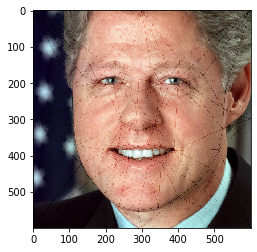

In [15]:
plt.imshow(output_aligned_images[0][:,:,::-1])

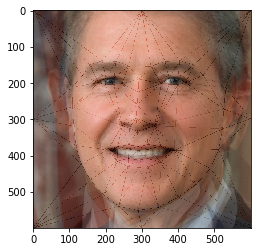

In [16]:
output_image = np.zeros((600,600,3),dtype=np.float32)
for image in output_aligned_images:
    output_image = cv2.add(output_image,np.float32(image))
    
output_image = (output_image/6).astype(np.uint8)
plt.imshow(output_image[:,:,::-1])

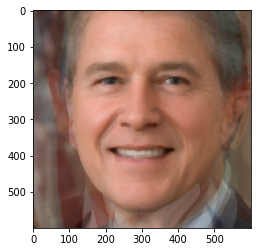

In [19]:
output_image = cv2.medianBlur(output_image,7)
plt.imshow(output_image[:,:,::-1])